In [1]:
import numpy as np
import torch
import sys, os
sys.path.append("../")
import matplotlib.pyplot as plt

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

%matplotlib inline

### Loading data

We will use the `pytorch` `Dataset` class for handling the data.

Here we wil load some data of 20 artificial neurons that are noisy oscillators. This data is an array of dimensions `num_trials x num_units x sequence_length`, which we use to initialise a `Basic_dataset_with_trials`.

If one has data without trial structure one can instead initialise the `Basic_dataset` class using an array of dimensions `num_units x sequence_length`.

In [2]:
from vi_rnn.datasets import Basic_dataset_with_trials

In [3]:
# load data
data_all = np.load("tutorial_data/continuous_data.npy")
n_trials, dim_x, seq_len = data_all.shape

# split into train and eval
train_inds = np.full((n_trials,),False)
train_inds[np.random.choice(np.arange(200),size=150,replace=False)]=True
data_train = data_all[train_inds]
data_eval = data_all[~train_inds]


# initialise a dataset class
task_params = {"name":"tutorial_cont"}
dataset = Basic_dataset_with_trials(data=data_train,
                                    data_eval = data_eval,
                                    task_params=task_params)

Text(0.5, 1.0, 'activity in trial 2')

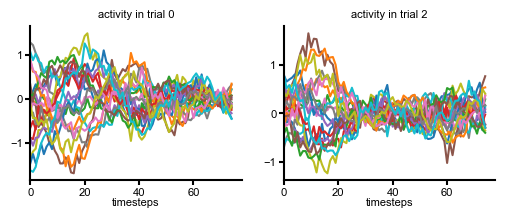

In [4]:
# plot some example data
fig,ax = plt.subplots(1,2,figsize=(6,2))
ax[0].plot(dataset.data[0].T);
ax[1].plot(dataset.data[2].T);
ax[0].set_xlim(0)
ax[1].set_xlim(0)
ax[0].set_xlabel("timesteps")
ax[1].set_xlabel("timesteps")
ax[0].set_title("activity in trial 0")
ax[1].set_title("activity in trial 2")

### Initialise the variational inference model

All the inference functions, and the model parameters are contained in the `VAE` class, which contains 

- All the RNN parameters in: `vae.rnn`
    - The dynamics / transition model is in: `vae.rnn.transition`
    - The observation model is in: `vae.rnn.observation`
- If used, the encoder parameters are in `vae.encoder`

In this example. we assume linear Gaussian observations, and use the Kalman Update step to update the RNN predictions (the so-called optimal proposal), so we don't need to train an encoding network.




We will here use a one-to-one mapping between RNN units and observations. Note that generally one does not have to do this - if you want a linear map between RNN units / latents and observations set `rnn_params["identity_readout"]` to `False`.


In [5]:
from vi_rnn.vae import VAE

In [ ]:
enc_params = {} # we can leave this empty as we don't need to train an encoder for linear Gaussian observations

rnn_params = {

    # noise covariances settings
    "train_noise_x": True, # whether or not to train the observation noise scale
    "train_noise_z": True, # whether or not to train the transition noise scale
    "train_noise_z_t0": True, # whether or not to train the initial state noise scale
    "init_noise_x": .1, # initial scale of the observation noise
    "init_noise_z": .1, # initial scale of the transition noise
    "init_noise_z_t0": .1, # initial scale of the initial state noise
    "noise_x": "diag", # observation covariance type ("diag" or "scalar"), can generally be left as diagional
    "noise_z": "full", # transition noise covariance type ("full", "diag" or "scalar"), set to "full" when using the optimal proposal
    "noise_z_t0": "full", # initial state noise covariance type ("full", "diag" or "scalar"), set to "full" when using the optimal proposal

    # readout settings
    "identity_readout": True, # if True enforces a one to one mapping between RNN units and recorded units
    "readout_from": "currents", # set to "currents", "rates", "z" or "z_and_v". We can readout from the RNN activity 
                                # before / after applying the non-linearty by setting this to "currents" / "rates" respectively.
                                # Alternatively we can directly readout from the latent dynamics z of the RNN by 
                                # setting this to "z", or from latents z and input v, by setting this to "z_and_v"
    "train_obs_bias": False, # whether or not to train a bias term in the observation model
    "train_obs_weights": False, # whether or not train the weights of the observation model 
    "out_nonlinearity":"identity", # can be used to rectify the output (e.g., when using Poisson observations, use "softplus")

    # other 
    "activation": "relu", # set the nonlinearity to "clipped_relu, "relu", "tanh" or "identity"
    "decay":.9, # initial decay constant, scalar between 0 and 1
    "train_neuron_bias": True, # train a bias term for every neuron
    "weight_dist": "uniform", # weight distribution ("uniform" or "gauss")
    "initial_state": "trainable", # initial state ("trainable", "zero", or "bias")
}


VAE_params = {
    "dim_x": 20, # observation dimension (number of units in the data)
    "dim_z": 2, # latent dimension / rank of the RNN
    "dim_N": 20, # amount of units in the RNN (can generally be different then the observation dim)
    "dim_u": 0, # input stimulus dimension
    "enc_architecture": "Inv_Obs", # encoder architecture (not trained when using linear Gauss observations)
    "enc_params": enc_params, # encoder paramaters
    "rnn_architecture": "LRRNN", # use a low-rank RNN architecture
    "rnn_params": rnn_params, # parameters of the RNN
}

# initialise the VAE
vae = VAE(VAE_params)

using ReLU activation
using uniform init


### Training

We will now fit an RNN to the data, using the `train_VAE` function. There are two inference functions that can be used during training:
- `training_params["loss_f"] = "opt_smc"` uses `vae.forward_optimal_proposal()`
- `training_params["loss_f"] = "smc"` uses `vae.forward()`

Here we use the first as observations are Gaussian and linear.


In [7]:
from vi_rnn.saving import save_model, load_model
from vi_rnn.train import train_VAE

In [ ]:
training_params = {
    "lr": 1e-3, # learning rate start
    "lr_end": 1e-5, # learning rate end (with exponential decay)
    "n_epochs": 2, # number of epochs to train
    "grad_norm": 0, # gradient clipping above certain norm (if this is set to >0)
    "batch_size": 16, # batch size
    "cuda": False, # train on GPU
    "k": 64, # number of particles to use
    "loss_f": "opt_smc", # use regular variational SMC ("smc"), or use the optimal ("opt_smc")
    "resample": "systematic",  #type of resampling "systematic", "multinomial" or "none"
    "run_eval": False, # run an evaluation setup during training (requires additional parameters)
    "observation_likelihood": "Gauss", # "Gauss"-ian  or "Poisson" observations
    "sim_v": False, # set to True when using time-varying inputs
}

In [ ]:
# run training
train_VAE(vae, training_params, dataset, sync_wandb=False, out_dir="tutorial_data", fname="tutorial_cont_new")

In [11]:
# As we only trained for a couple of epochs we will load a pretrained model
# This was trained as above, but for 500 epochs
vae, vae_params, task_params, training_params = load_model("tutorial_data/tutorial_cont")

identity
using ReLU activation
using uniform init


### Plot the trained model's output

To generate data from our trained model, we can use the `predict` function. We can either use a data-inferred initial state, by passing the data and the argument `initial_state="posterior_mean"` or just sample from the RNNs initial state by passing `initial_state="prior_mean"`.

Generally we get nicer visualisation of the latent dynamics by projecting the data on an orthogonalised basis. We here use the basis spanned by the left singular vectors of the RNNs weight matrix, which we obtain using the function `get_orth_proj_latents`.

In [12]:
from vi_rnn.predict import predict
from vi_rnn.utils import get_orth_proj_latents

In [13]:
# generate data using our fit model
Z_gen, data_gen, rates_gen = predict(vae,u=None,x=dataset.data_eval,initial_state="posterior_mean",optimal_proposal=True)

In [14]:
# orthogonalise the latents
projection_matrix = get_orth_proj_latents(vae)
Z_gen_orth = np.einsum("BZT,OZ->BOT",Z_gen,projection_matrix)


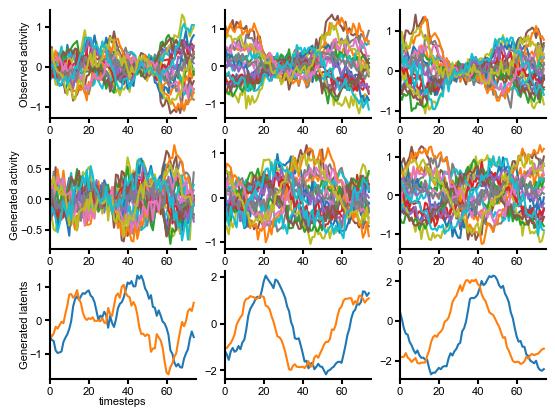

In [16]:
# plot data generated by our model next to evaluation data
# NOTE: we do not expect a timestep wise correspondance, as we are plotting samples from a stochastic
# model. Instead we expect the distributions over samples to match.

fig,ax = plt.subplots(3,3)

ax[0,0].set_ylabel("Observed activity")
ax[0,0].plot(dataset.data_eval[0].T);
ax[0,1].plot(dataset.data_eval[1].T);
ax[0,2].plot(dataset.data_eval[2].T);

ax[1,0].set_ylabel("Generated activity")
ax[1,0].plot(data_gen[0].T);
ax[1,1].plot(data_gen[1].T);
ax[1,2].plot(data_gen[2].T);

ax[2,0].set_ylabel("Generated latents")
ax[2,0].plot(Z_gen_orth[0].T);
ax[2,1].plot(Z_gen_orth[1].T);
ax[2,2].plot(Z_gen_orth[2].T);
ax[2,0].set_xlabel("timesteps")

for a in ax.flatten():
    a.set_xlim(0,75)